# Introduction

The data that is used in this notebook is described at the following link: 

- https://www.statsmodels.org/devel/datasets/generated/co2.html 

# Section 1: Importations

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 

import numpy as np 
import copy 

# time-series packages: 
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import timeit

# Section 2: Load the weekly data for CO2/Carbon dioxide, and plot the time series

In [2]:
data = sm.datasets.co2.load_pandas().data

"data" represents weekly CO2 data that is available via the statsmodels library. 

In [3]:
def show_data_and_summary_stats(df):
    """
    Show the data and show summary statistics on the data.
    """
    display(df)
    print('------------------------------')
    print('Display the shape of the dataframe:' , df.shape)
    print('------------------------------')
    print('Display the type of each column:' , df.dtypes)
    print('------------------------------')
    print('Display the type of the index:' , type(df.index)) 
    print('------------------------------')
    min_date = df.index.min() 
    max_date = df.index.max() 
    print('Display the minimum date and the maximum date:', (min_date, max_date))
    print('------------------------------')
    print('Summary statistics: \n', df.describe())
    print('------------------------------')
    print('Display the number of missing values: \n', df.isna().sum() )
    return None

show_data_and_summary_stats(data)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


------------------------------
Display the shape of the dataframe: (2284, 1)
------------------------------
Display the type of each column: co2    float64
dtype: object
------------------------------
Display the type of the index: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
------------------------------
Display the minimum date and the maximum date: (Timestamp('1958-03-29 00:00:00', freq='W-SAT'), Timestamp('2001-12-29 00:00:00', freq='W-SAT'))
------------------------------
Summary statistics: 
                co2
count  2225.000000
mean    340.142247
std      17.003885
min     313.000000
25%     324.800000
50%     338.300000
75%     354.800000
max     373.900000
------------------------------
Display the number of missing values: 
 co2    59
dtype: int64


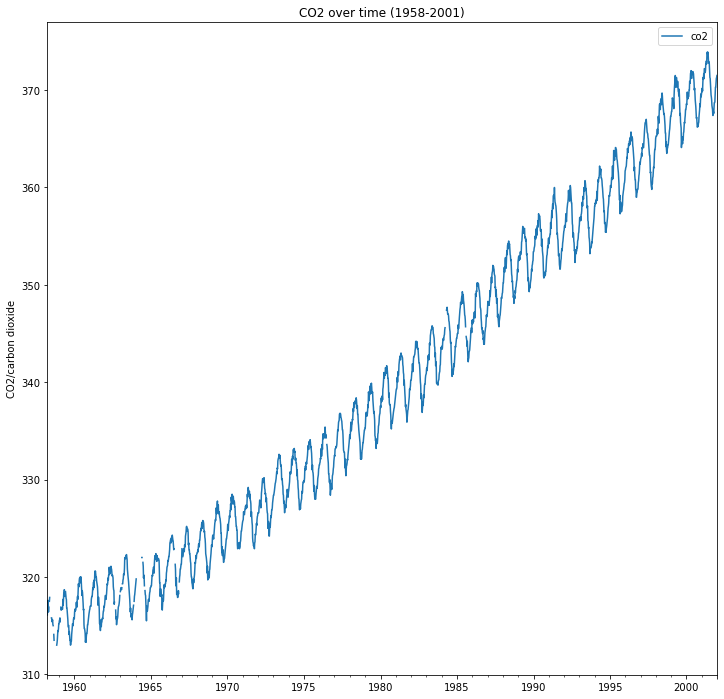

In [4]:
def plot_data(df):
    """
    Plot the data.
    """
#     plt.figure(figsize=(12,12))
#     plt.plot(data)
#     plt.ylabel('CO2/carbon dioxide')
#     plt.title('CO2 over time (1958-2001)')
#     plt.show()
    ax = df.plot(figsize=(12,12))
    ax.set_title('CO2 over time (1958-2001)')
    ax.set_ylabel('CO2/carbon dioxide')
    plt.show()    
    return None
    
plot_data(data)

there are some NA-s (see the holes in the above graph)

# Section 3: Handling the missing values of CO2

In [5]:
print('The number of missing values is: ', data[data.co2.isna()].shape[0])

print('Percentage of missing values is:',  (data[data.co2.isna()].shape[0] / data.shape[0]) * 100, '%')

The number of missing values is:  59
Percentage of missing values is: 2.583187390542907 %


The below function replaces the missing values. Since there are many consecutive missing values, I do not use the average between the past value and the future value (of a mising value). I simply use the average by year to impute the missing values. This is done because there is a clear upward trend (see above graph), and thus using the average across all years would be misleading. 

In [6]:
def impute_missing_values_co2(df):
    """
    Replace the missing values using the average value by year. 
    """
    
    # temporarily add a year column:
    df['year'] = df.index.year
    # create a dictionary with the averages of co2 by year: 
    grouped_values = df.groupby('year')['co2'].mean() # compute the mean of co2 for each year
    dictionary_grouped_values = dict(grouped_values)
    # create a temporary column which stores the average by year:
    df['averaged_co2_by_year'] = df['year'].map(lambda x: dictionary_grouped_values[x])
    # assign/fill the mising values of co2: 
    df['co2'] = df['co2'].fillna(df['averaged_co2_by_year'])
    # test:
    assert df['co2'].isna().sum() == 0 
    # delete redundant columns: 
    df = df.drop(columns=['year', 'averaged_co2_by_year'])
    
    return df 

In [7]:
data = impute_missing_values_co2(data)

In [8]:
data.isna().sum()

co2    0
dtype: int64

In [9]:
# Another test: 
    
# data['year'] = data.index.year
# grouped_values = data.groupby('year')['co2'].mean() # compute the mean of co2 for each year
# dictionary_grouped_values = dict(grouped_values)
# data['averaged_co2_by_year'] = data['year'].map(lambda x: dictionary_grouped_values[x])
# data['co2'] = data['co2'].fillna(data['averaged_co2_by_year'])
# data[data.co2 == data.averaged_co2_by_year].shape

plot the data again: 

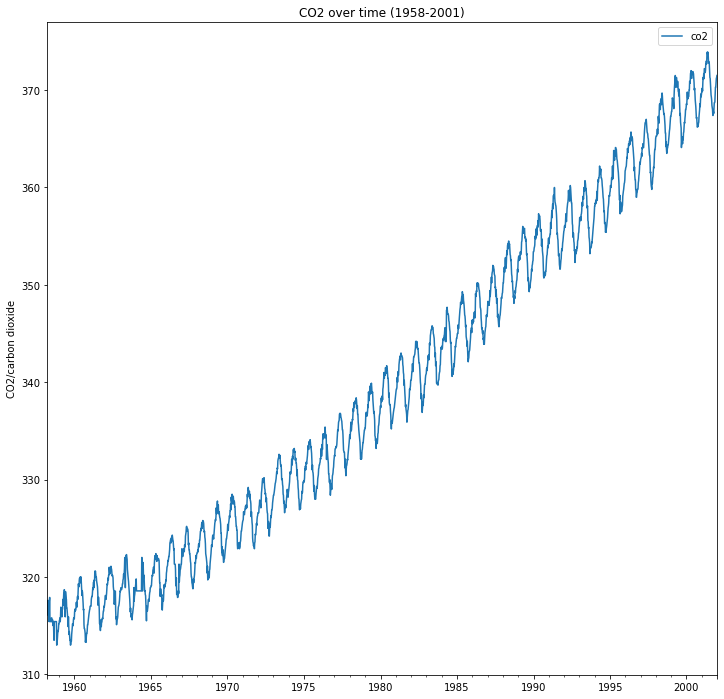

In [10]:
plot_data(data)

The latest graph looks reasonable in terms of the imputed values. 

# Section 4: Time Series Decomposition


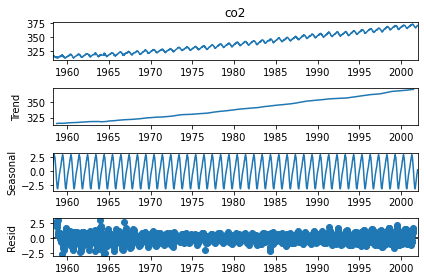

In [29]:
def plot_decomposition(df, col_name):
    """
    Decompose the time-series using seasonal_decompose() method, and then plot the decomposition.
    """
    decomposition = seasonal_decompose(df[col_name], model='additive', period=52)
    fig = decomposition.plot()
    plt.show()
    return None

plot_decomposition(data, 'co2')

There is a clear upward trend. Thus, the process looks like it needs to be stationarized. 

# Section 5: Transform the data into a numpy array

In [12]:
# transform the pandas dataframe into a numpy array:

def transform_into_numpy_array(df, col_name):
    """
    Transform the pandas dataframe into a numpy array suitable for the ARIMA() method.
    """
    data_array = df[[col_name]].values
    return data_array

data_array = transform_into_numpy_array(data, 'co2')
type(data_array)

numpy.ndarray

In [13]:
len(data_array)

2284

In [14]:
data_array

array([[316.1],
       [317.3],
       [317.6],
       ...,
       [371.2],
       [371.3],
       [371.5]])

# Section 6: fitting a SARIMA model, and use multi-step forecasting (10-periods-ahead forecating strategy)

We fit a SARIMA model in this section. We fit the SARIMA(1,1,1)(1,1,1)-52 model, that is: 
The ARIMA conponents are: 
- p = 1
- q = 1
- d = 1 

The seasonal ARIMA components are: 
- P = 1
- Q = 1
- D = 1

Finally, the periodicity is 52 (see above), as the data is weekly data. 

In [15]:
train = data_array[:-10]
test = data_array[-10:]

In [16]:
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
res = model.fit(disp=False) # (disp=False) suppresses the output
forecasts = res.forecast(steps=10)

/home/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


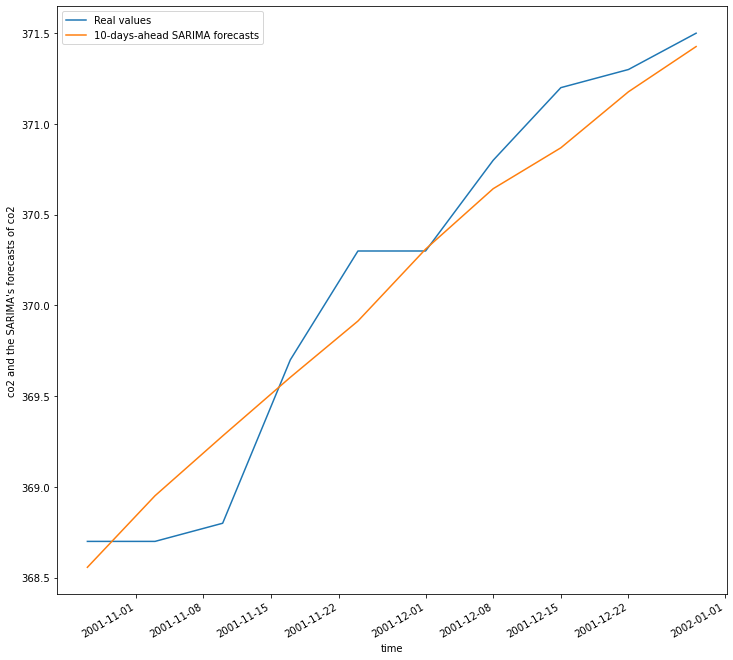

In [17]:
def join_forecasts_true_values(df, forecasts):
    """
    Create a pandas dataframe containing the forecasts and the real values. 
    """
    # restricted_df = df.tail(10) 
    restricted_df = df.iloc[-10:, :] 
    # adding the forecasts in the "forecasts" column:
    restricted_df['forecasts'] = forecasts
    return restricted_df

last_10_periods = join_forecasts_true_values(data, forecasts)
last_10_periods

def plot_forecasts_and_real_values(df, col_name_real_val, col_name_forecasts):
    """
    Plot forecasts and real values. 
    """
    plt.figure(figsize=(12,12))
    plt.plot(df[col_name_real_val])
    plt.plot(df[col_name_forecasts])
    plt.xlabel('time')
    plt.ylabel('co2 and the SARIMA\'s forecasts of co2')
    plt.legend(['Real values', '10-days-ahead SARIMA forecasts'])
    plt.gcf().autofmt_xdate() # (gcf().autofmt_xdate()) automatically selects the dates for the x-axis.
    plt.show()
    return None 


plot_forecasts_and_real_values(last_10_periods, 'co2', 'forecasts')

Calculate RMSE: 

In [18]:
def calculate_rmse(df, col_name_real_values, col_name_forecasts):
    """
    Calculate RMSE directly without importing libraries.
    """
    rmse = (((df[col_name_real_values] - df[col_name_forecasts])**2).mean())**0.5
    return rmse

rmse = calculate_rmse(last_10_periods, 'co2', 'forecasts')
rmse 

0.2506221485445512

In [19]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(test, forecasts)**0.5)

0.2506221485445512


Considering that the average of "co2" column is around 370 for the last 10 weeks, the RMSE of 0.25 seems to be low. 

Calculate the R-squared: 
    

In [20]:
r2_score(test, forecasts)

0.9425907491627029

The R-squared is good, as it is equal to 0.94. Considering that this is a SARIMA model that we picked up randomly without any model tuning/grid search, etcetera, it looks like a promising model for the CO2 data **(Note: this is just some suggestive evidence. To be more precise, it is needed to use CV to draw a more precise conclusion about the performance on the test/unseen set.)**

# Section 7: fitting a SARIMA model using an iterative 1-period-ahead forecasting strategy

We fit a SARIMA model in this section. We fit the SARIMA(1,1,1)(1,1,1)-52 model, that is: 
The ARIMA conponents are: 
- p = 1
- q = 1
- d = 1 

The seasonal ARIMA components are: 
- P = 1
- Q = 1
- D = 1

Finally, the periodicity is 52 (see above), as the data is weekly data. 

In [21]:
train = data_array[:-10]
test = data_array[-10:]

test_original = copy.deepcopy(test)

In [22]:
forecasts = []

for i in range(10):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
    res = model.fit(disp=False) # (disp=False) suppresses the output
    fcst = res.forecast(steps=1)
    #append fcst to forecasts: 
    forecasts.append(fcst)
    
    # update train and test: 
    train = np.concatenate((train, test[0:1, :])) # concatenate the 1st observation of test to train. 
    test = test[1:] # update test and get rid of the 1st observation.    

/home/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


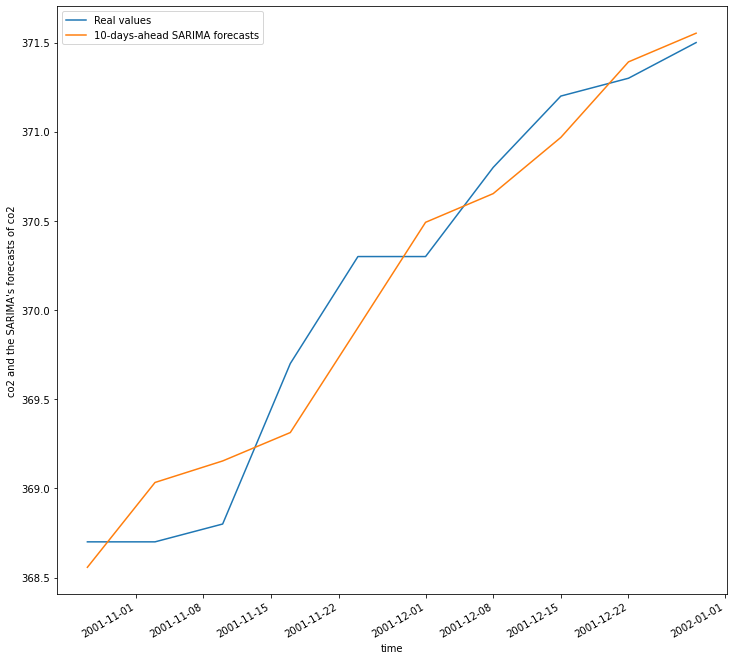

In [23]:
def join_forecasts_true_values(df, forecasts):
    """
    Create a pandas dataframe containing the forecasts and the real values. 
    """
    # restricted_df = df.tail(10) 
    restricted_df = df.iloc[-10:, :] 
    # adding the forecasts in the "forecasts" column:
    restricted_df['forecasts'] = forecasts
    return restricted_df

last_10_periods = join_forecasts_true_values(data, forecasts)
last_10_periods

def plot_forecasts_and_real_values(df, col_name_real_val, col_name_forecasts):
    """
    Plot forecasts and real values. 
    """
    plt.figure(figsize=(12,12))
    plt.plot(df[col_name_real_val])
    plt.plot(df[col_name_forecasts])
    plt.xlabel('time')
    plt.ylabel('co2 and the SARIMA\'s forecasts of co2')
    plt.legend(['Real values', '10-days-ahead SARIMA forecasts'])
    plt.gcf().autofmt_xdate() # (gcf().autofmt_xdate()) automatically selects the dates for the x-axis.
    plt.show()
    return None 


plot_forecasts_and_real_values(last_10_periods, 'co2', 'forecasts')

Calculate RMSE: 

In [24]:
def calculate_rmse(df, col_name_real_values, col_name_forecasts):
    """
    Calculate RMSE directly without importing libraries.
    """
    rmse = (((df[col_name_real_values] - df[col_name_forecasts])**2).mean())**0.5
    return rmse

rmse = calculate_rmse(last_10_periods, 'co2', 'forecasts')
rmse 

array([0.26237425])

In [25]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(last_10_periods['co2'], last_10_periods['forecasts'])**0.5)

0.2623742505306259


Considering that the average of "co2" column is around 370 for the last 10 weeks, the RMSE of 0.25 seems to be low. 

Calculate the R-squared: 
    

In [26]:
r2_score(last_10_periods['co2'], last_10_periods['forecasts'])

0.9370804795343138

**Conclusion: the iterative 1-period-ahead forecasting strategy isn't better than the multi-step forecasting strategy.** 
    
**Thus, for simplicity and due to the lengthy computational processes of SARIMA, we will simply use the the multi-step forecasting strategy: the 10-periods-ahead forecasting strategy.**



# Section 8: Grid search to find the best SARIMA model (Hyperparameter tuning)

**Below we construct a grid search to find the best hype-parameters. We use all models such that:** 

ARIMA parameters: 
- p can take any value in this set: (0,1,2).
- d can take any value in this set: (1).
- q can take any value in this set: (0,1,2).

Seasonal ARIMA parameters: 
- P can take any value in this set: (0,1,2).
- D can take any value in this set: (1).
- Q can take any value in this set: (0,1,2).

That is, the grid search includes 81 models (3^4 models).

In [27]:
# Re-create data_array:
data_array = data[['co2']].values

train = data_array[:-10]
test = data_array[-10:]

In [28]:
# import timeit

starttime = timeit.default_timer()

In [30]:
cv_results = []

for p in (0,1):
    for d in (0,1,):
        for q in (0,1):
            for P in (0,1):
                for D in (0,1):
                    for Q in (0,1):
                        # fit the model, and forecast 10 periods ahead: 
                        model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q, 52))
                        
                        try: 
                            res = model.fit(disp=False)
                            forecasts = res.forecast(steps=10)
                        
                            # store r-squared and rmse:
                            r_squared = r2_score(test, forecasts)
                            rmse = mean_squared_error(test, forecasts)**0.5
                        except: 
                            print('An error occured.')
                            forecasts = [-9999999999999 for x in range(10)]                            
                            r_squared = -9999999999999
                            rmse = +9999999999999
                            
                        results_single_model = [p, d, q, P, D, Q, forecasts, r_squared, rmse]
                        cv_results.append(results_single_model)
                        
pd_cv_results = pd.DataFrame(cv_results)                     
pd_cv_results.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'forecasts', 'r_squared', 'rmse']    
pd_cv_results_sorted_rsq = pd_cv_results.copy(deep=True).sort_values('r_squared', ascending=False)
pd_cv_results_sorted_rmse  = pd_cv_results.copy(deep=True).sort_values('rmse', ascending=True)                        

/home/nick/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/nick/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/nick/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/nick/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/nick/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stat

/home/nick/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/nick/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/nick/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/nick/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [31]:
endtime = timeit.default_timer()

print('time it took in seconds:  ')
display(endtime - starttime) 

time it took in seconds:  


1184.5035591489977

In [32]:
display(pd_cv_results_sorted_rsq)
display(pd_cv_results_sorted_rmse)

,p,d,q,P,D,Q,forecasts,r_squared,rmse
63,1,1,1,1,1,1,"[368.55720730720094, 368.9515132059826, 369.28...",0.942591,0.250622
59,1,1,1,0,1,1,"[368.57479941792366, 368.9553816292382, 369.28...",0.936945,0.262657
31,0,1,1,1,1,1,"[368.46618081035257, 368.82964698025745, 369.1...",0.909519,0.314636
27,0,1,1,0,1,1,"[368.48138249994724, 368.83457900735937, 369.1...",0.901518,0.328251
47,1,0,1,1,1,1,"[368.45878554764204, 368.8186742551845, 369.13...",0.898351,0.333488
...,...,...,...,...,...,...,...,...,...
56,1,1,1,0,0,0,"[368.0901977755481, 368.08150701737003, 368.07...",-3.943454,2.325647
9,0,0,1,0,0,1,"[277.81189147707204, 183.81844719144524, 184.6...",-29101.846182,178.441654
1,0,0,0,0,0,1,"[183.80447467001025, 183.82720136063006, 184.6...",-31468.699806,185.555918
8,0,0,1,0,0,0,"[185.27657299990886, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-115863.872824,356.044600


,p,d,q,P,D,Q,forecasts,r_squared,rmse
63,1,1,1,1,1,1,"[368.55720730720094, 368.9515132059826, 369.28...",0.942591,0.250622
59,1,1,1,0,1,1,"[368.57479941792366, 368.9553816292382, 369.28...",0.936945,0.262657
31,0,1,1,1,1,1,"[368.46618081035257, 368.82964698025745, 369.1...",0.909519,0.314636
27,0,1,1,0,1,1,"[368.48138249994724, 368.83457900735937, 369.1...",0.901518,0.328251
47,1,0,1,1,1,1,"[368.45878554764204, 368.8186742551845, 369.13...",0.898351,0.333488
...,...,...,...,...,...,...,...,...,...
56,1,1,1,0,0,0,"[368.0901977755481, 368.08150701737003, 368.07...",-3.943454,2.325647
9,0,0,1,0,0,1,"[277.81189147707204, 183.81844719144524, 184.6...",-29101.846182,178.441654
1,0,0,0,0,0,1,"[183.80447467001025, 183.82720136063006, 184.6...",-31468.699806,185.555918
8,0,0,1,0,0,0,"[185.27657299990886, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-115863.872824,356.044600


conclusions: 
- the best model based on r-squared is: SARIMA(1,1,1)(1,1,1)-52
- the best model based on rmse is: SARIMA(1,1,1)(1,1,1)-52
    

# Section 9: Final fitting and forecasting using the best model selected by Grid Search 

**The best model selected by Grid Search  is SARIMA(1,1,1)(1,1,1)-52**

We fit a SARIMA model in this section. We fit the SARIMA(1,1,1)(1,1,1)-52 model, that is: 
The ARIMA conponents are: 
- p = 1
- q = 1
- d = 1 

The seasonal ARIMA components are: 
- P = 1
- Q = 1
- D = 1

Finally, the periodicity is 52 (see above), as the data is weekly data. 

In [32]:
train = data_array[:-10]
test = data_array[-10:]

In [33]:
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
res = model.fit(disp=False) # (disp=False) suppresses the output
forecasts = res.forecast(steps=10)

/home/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


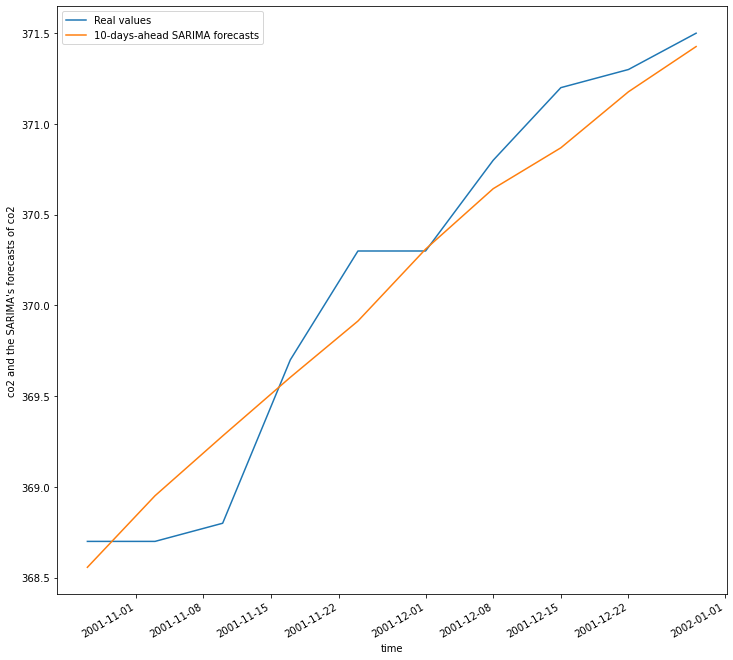

In [34]:
def join_forecasts_true_values(df, forecasts):
    """
    Create a pandas dataframe containing the forecasts and the real values. 
    """
    # restricted_df = df.tail(10) 
    restricted_df = df.iloc[-10:, :] 
    # adding the forecasts in the "forecasts" column:
    restricted_df['forecasts'] = forecasts
    return restricted_df

last_10_periods = join_forecasts_true_values(data, forecasts)
last_10_periods

def plot_forecasts_and_real_values(df, col_name_real_val, col_name_forecasts):
    """
    Plot forecasts and real values. 
    """
    plt.figure(figsize=(12,12))
    plt.plot(df[col_name_real_val])
    plt.plot(df[col_name_forecasts])
    plt.xlabel('time')
    plt.ylabel('co2 and the SARIMA\'s forecasts of co2')
    plt.legend(['Real values', '10-days-ahead SARIMA forecasts'])
    plt.gcf().autofmt_xdate() # (gcf().autofmt_xdate()) automatically selects the dates for the x-axis.
    plt.show()
    return None 


plot_forecasts_and_real_values(last_10_periods, 'co2', 'forecasts')

Calculate RMSE: 

In [35]:
def calculate_rmse(df, col_name_real_values, col_name_forecasts):
    """
    Calculate RMSE directly without importing libraries.
    """
    rmse = (((df[col_name_real_values] - df[col_name_forecasts])**2).mean())**0.5
    return rmse

rmse = calculate_rmse(last_10_periods, 'co2', 'forecasts')
rmse 

0.2506221485445512

In [36]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(test, forecasts)**0.5)

0.2506221485445512


Calculate the R-squared: 
    

In [37]:
r2_score(test, forecasts)

0.9425907491627029